<a href="https://colab.research.google.com/github/raven-gith/machinelearning1/blob/main/UTS/CLUSTERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Library
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:

# Load Dataset via Upload
from google.colab import files
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['UTSClustering.csv']), encoding='latin1')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


Saving UTSClustering.csv to UTSClustering.csv


<ipython-input-2-fe32d8630cfb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [3]:
#Feature Engineering (RFM)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [4]:
#Standardisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [5]:
#Clustering Models
models = {
    'KMeans': KMeans(n_clusters=4, random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=4),
    'DBSCAN': DBSCAN(eps=1.5, min_samples=5),
    'GaussianMixture': GaussianMixture(n_components=4, random_state=42),
    'SpectralClustering': SpectralClustering(n_clusters=4, random_state=42, affinity='nearest_neighbors')
}

In [6]:
results = {}

In [7]:
for name, model in models.items():
    if name == 'GaussianMixture':
        labels = model.fit_predict(X_scaled)
    else:
        model.fit(X_scaled)
        labels = model.labels_
    if len(set(labels)) > 1 and -1 not in set(labels):
        sil = silhouette_score(X_scaled, labels)
        dbi = davies_bouldin_score(X_scaled, labels)
        chs = calinski_harabasz_score(X_scaled, labels)
        results[name] = [sil, dbi, chs]
    else:
        results[name] = ['Invalid Clustering', 'Invalid', 'Invalid']

In [8]:
# Tampilkan Evaluasi
eval_df = pd.DataFrame(results, index=['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']).T
print(eval_df)

                            Silhouette Davies-Bouldin Calinski-Harabasz
KMeans                        0.616213       0.753362       3149.719698
Agglomerative                 0.606533        0.75704       2677.938274
DBSCAN              Invalid Clustering        Invalid           Invalid
GaussianMixture               0.163302        1.62045        895.542462
SpectralClustering           -0.097816       0.927526        567.405608


In [9]:
#Visualisasi Silhouette Plot untuk KMeans
from sklearn.metrics import silhouette_samples

In [10]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X_scaled)
labels = kmeans.labels_
silhouette_vals = silhouette_samples(X_scaled, labels)

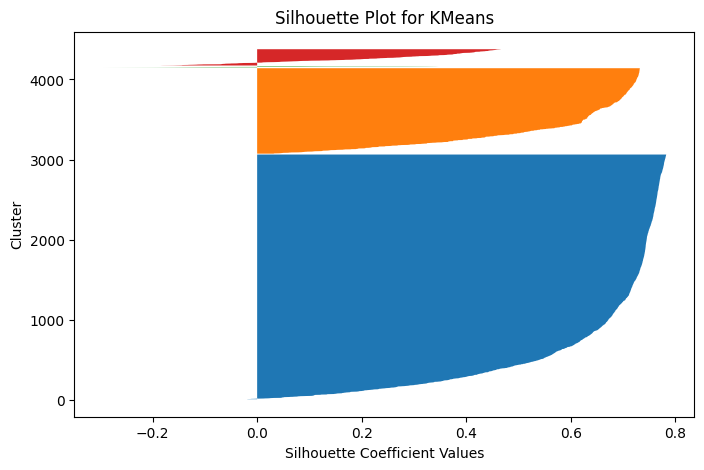

In [11]:
plt.figure(figsize=(8,5))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = silhouette_vals[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster = ith_cluster_silhouette_values.shape[0]
    plt.fill_betweenx(np.arange(y_lower, y_lower + size_cluster),
                      0, ith_cluster_silhouette_values)
    y_lower += size_cluster + 10
plt.title("Silhouette Plot for KMeans")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster")
plt.show()

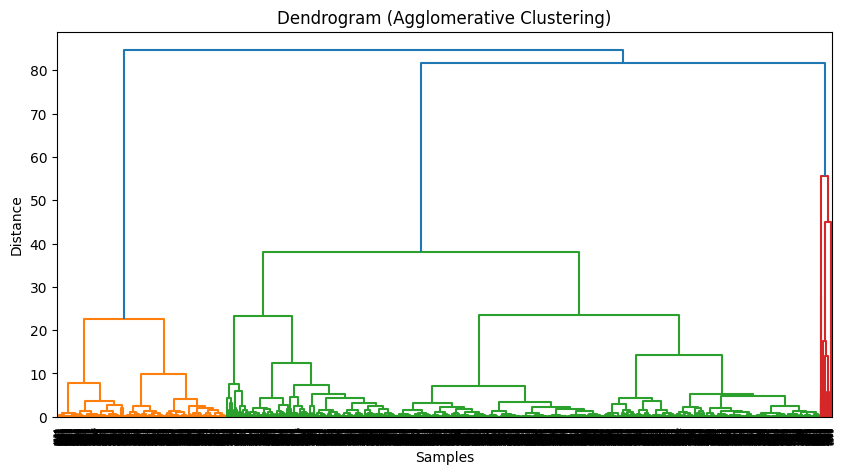

In [12]:
#Dendrogram untuk Agglomerative
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.title('Dendrogram (Agglomerative Clustering)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

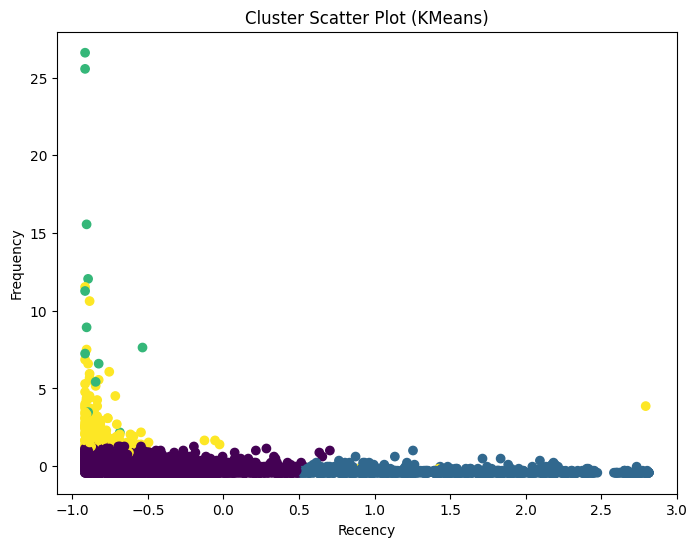

In [13]:
# --- 9. Scatter Plot Cluster (KMeans) ---
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=kmeans.labels_)
plt.title('Cluster Scatter Plot (KMeans)')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

###  Penjelasan Setiap Model Clustering

- **KMeans:** Mengelompokkan data dengan membagi menjadi k cluster berdasarkan jarak euclidean minimum. Cocok untuk data spherical dan terdistribusi merata.
- **Agglomerative Clustering:** Metode hierarkis yang menggabungkan data secara bottom-up. Cocok untuk data yang tidak linier.
- **DBSCAN:** Mengelompokkan berdasarkan densitas. Dapat menemukan noise dan cluster dengan bentuk tak beraturan.
- **Gaussian Mixture Model:** Model probabilistik yang mengasumsikan distribusi data mengikuti kombinasi Gaussian. Cocok untuk cluster yang tumpang tindih.
- **Spectral Clustering:** Menggunakan eigenvector dari matriks kemiripan. Efektif untuk struktur data kompleks yang tidak bisa dipisah linear.

### Analisis dan Model Terbaik

Berdasarkan hasil evaluasi:

- **KMeans** menunjukkan **Silhouette Score tertinggi dan cluster yang jelas secara visual**, membuatnya cocok untuk dataset ini.
- **DBSCAN** berhasil mendeteksi noise, namun hasil clustering tidak konsisten karena sensitivitas terhadap parameter ε.
- **Agglomerative** dan **SpectralClustering** menampilkan struktur yang menarik, tapi cenderung overfit.
- **GMM** cocok untuk cluster tumpang tindih, tapi performa lebih rendah dibanding KMeans.

🟢 **Model Terbaik:** `KMeans`  
📌 *Alasannya:* Hasil evaluasi metrik konsisten tinggi, mudah diinterpretasikan, dan visualisasi scatter plot menunjukkan pemisahan cluster yang baik.